# Experiment-1: Linear Regression and Stochastic Gradient Descent
## In this experiment, we will: 
- (1) Get more intuitions about Linear Regression, Closed Form Solution and Gradient Descent. 
- (2) Get your hands dirty on [Housing dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html#housing), which is one of the [LIBSVM Dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).
- (3) Get some experience about hyper-parameter tuning.
### Note that, In this and the following experiments, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml), which means simple machine learning, written by [lizhaoliu-Lec](https://github.com/lizhaoliu-Lec/).

In [1]:
# First, do a little setup
%pip install simple_ml
import simple_ml
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from simple_ml.utils.metric import square_error
from simple_ml.linear.model import LinearRegression
from simple_ml.linear import RidgeRegression
from simple_ml.nn.layer import Input, Linear
from simple_ml.nn.model import Model
from simple_ml.nn.initializer import zeros, ones
from simple_ml.nn.optimizer import SGD, Momentum, Adam, RMSProp
from simple_ml.utils.metric import absolute_error, square_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the (preprocessed) Housing data.
# fix random seed
np.random.seed(1234)

# read the data
def get_housing_data(data_path='./tmp/exp1/housing.scale', test_size=0.33):
    X, y = load_svmlight_file(data_path)
    # convert sparse matrix to numpy array
    X = X.A
    y = np.reshape(y, (-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_housing_data()
print('We have `%d` training examples and `%d` test examples' % (X_train.shape[0], X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_test shape: ', y_test.shape)
print('But we set aside 20% of the training examples for validation.\n')
val_split = 0.2
val_size = int(X_train.shape[0] * val_split)
X_val, y_val, X_train, y_train = X_train[:val_size], y_train[:val_size], X_train[val_size:], y_train[val_size:]
print('Finally, we have...')
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

We have `339` training examples and `167` test examples
X_train shape:  (339, 13) , X_test shape:  (167, 13)
y_train shape:  (339, 1) , y_test shape:  (167, 1)
But we set aside 20% of the training examples for validation.

Finally, we have...
We have `272` training examples, `67` validation examples and `167` test examples
X_train shape:  (272, 13) , X_val shape:  (67, 13) , X_test shape:  (167, 13)
y_train shape:  (272, 1) , y_val shape:  (67, 1) , y_test shape:  (167, 1)


## Normalized the data:
Normalized the data is very important, typically, we want to normalized the data between 0~1, which is perfect for linear model or svm, and even some deep learning model.
Although the housing data is scaled so that every last number of it is between -1~1, but we are still doing it, for a heads up reminder in the first experiments.

Remember! Normalize the data is very important, especially in the deep learning model.

To normalized the data, we need to normalized all, which means normalized X_train, X_val and X_test, y is not under our consideration in this experiment.
But, X_val and X_test, especially X_test must stayed unseen, during training the model and normalization! 

So we Fit a Standarizer, which compute the mean and variance of X_train, and apply them to the X_val and X_test.
Again, the mean and the variance are computed from X_train only!  

In [8]:
from simple_ml.preprocessing import Standardizer

print('Before normalized the data...')
print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))
standardizer = Standardizer()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_val = standardizer.transform(X_val)
X_test = standardizer.transform(X_test)

print('\nAfter normalized the data...')
print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))

Before normalized the data...
*** X_train *** 
mean: 
[-0.92490121 -0.76386029 -0.22109227 -0.86764706 -0.30062634  0.05911235
  0.35636396 -0.51109444 -0.28548581 -0.1803436   0.20353563  0.79197803
 -0.40424947] 
variance: 
[0.03239975 0.21513841 0.26442812 0.24718858 0.22807535 0.07517604
 0.31523833 0.15272017 0.56639047 0.4068549  0.23006609 0.21599302
 0.15109431]
*** X_val *** 
mean: 
[-0.92441909 -0.77298507 -0.15522825 -0.76119403 -0.24752779  0.0640971
  0.37602409 -0.56203232 -0.16807258 -0.03776927  0.20895518  0.86291824
 -0.41189747] 
variance: 
[0.01920711 0.19224781 0.23963173 0.42058365 0.25501171 0.07961023
 0.39206133 0.14534387 0.55575961 0.36489576 0.21768363 0.12629608
 0.17887229]
*** X_test *** 
mean: 
[-0.90694713 -0.78706587 -0.23585968 -0.89221557 -0.32508072  0.01052926
  0.33745693 -0.50321133 -0.24498815 -0.16252237  0.32959607  0.77914431
 -0.37976696] 
variance: 
[0.05236771 0.23006744 0.23622188 0.20395138 0.21212914 0.06319293
 0.34531654 0.13539334 0.

## Linear Regression: directly optimize it with Closed Form Solution.
We first recap the derivation of Closed Form Solution.
Given $$ \textbf{X} \in \mathbb{R}^{m \times n} $$, where m is the number of examples, and n is the number of features;

And learnable parameter $$ \textbf{w} \in \mathbb{R}^{n \times h}$$, $$ \textbf{b} \in \mathbb{R}^{h}$$.

Linear Model is $$ \textbf{y} = \textbf{X} \cdot \textbf{w} + \textbf{b} $$.

We can add a column of ones in $$ \textbf{X} $$, so it become fully Vectorized form, because we concate $$ \textbf{w} $$ and $$ \textbf{b} $$ together. 

So we get $$ \textbf{X} \in \mathbb{R}^{m \times (n + 1)}$$ and learnable parameter $$ \textbf{W} \in \mathbb{R}^{(n + 1) \times h}$$

Then we make the derivation of Closed Form Solution.
For Linear Regression problem, we want to minimize the loss function $$ J(\hat{y}, y) = \frac{1}{2m}\Sigma_{i=1}^{m}(\hat{y}_{i} - y_{i})  $$

where $$ \hat{y} =  \textbf{X} \cdot \textbf{W} \in \mathbb{R}^{m \times h}$$ is prediction output by the Linear Model.

We can write it as Vectorized form as \begin{eqnarray} J(\hat{y}, y) &=& \frac{1}{2m}(\hat{y} - y)^{T} \cdot (\hat{y} - y) \\
&=& \frac{1}{2m}(\textbf{X} \textbf{W} - y)^{T} \cdot (\textbf{X} \textbf{W} - y) \\
\textbf{W}^{*} &=& \mathop{\arg\min}_{W} J(\hat{y}, y) \end{eqnarray} 

Set $$ \frac{\partial{J}}{\partial{W}} = 0 $$, we get $$ \textbf{W}^{*} = (\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}\textbf{y} $$
Note that $$ (\textbf{X}^{T}\textbf{X}) $$ maybe uninvertible, so in practice, we use pesudo inverse or Ridge Regression.

Now, it's time to get your hands dirty!

In [4]:
# we first build the linear regression model.

# build the linear model
print(10 * '*' + ' LinearRegression model begin ' + 10 * '*')
linear_regression = LinearRegression()
# get closed form solution
linear_regression.fit(X_train, y_train)
test_y_hat = linear_regression.predict(X_test)
train_y_hat = linear_regression.predict(X_train)
training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
test_error = square_error(y_test, test_y_hat) / y_test.shape[0]
print('Training mean square error: ', training_error)
print('Test mean square error: ', test_error)
print(10 * '*' + ' LinearRegression model end ' + 10 * '*')
print()

********** LinearRegression model begin **********
Training mean square error:  10.234859706513923
Test mean square error:  10.201081572149134
********** LinearRegression model end **********



## Ridge Regression
Ridge Regression model can be seen as a regularized Linear Model.

And it doesn't have any un invertible problem when getting closed form solution.

The closed form solution of ridge regression is computed as following.
$$ \textbf{W}^{*} = (\textbf{X}^{T}\textbf{X} + \lambda \mathbb{I})^{-1}\textbf{X}^{T}\textbf{y} $$

In [5]:
# build the ridge regression model
print(10 * '*' + ' Ridge LinearRegression model begin ' + 10 * '*')
# the lambda is represented as alpha in the API, by default, alpha=1
ridge_regression = RidgeRegression(alpha=1)
# get closed form solution
ridge_regression.fit(X_train, y_train)
test_y_hat = ridge_regression.predict(X_test)
train_y_hat = ridge_regression.predict(X_train)
training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
test_error = square_error(y_test, test_y_hat) / y_test.shape[0]
print('Training mean square error: ', training_error)
print('Test mean square error: ', test_error)
print(10 * '*' + ' Ridge LinearRegression model end ' + 10 * '*')
print()

********** Ridge LinearRegression model begin **********
Training mean square error:  10.23951213883928
Test mean square error:  10.251246074694555
********** Ridge LinearRegression model end **********



## Different lambdas in Ridge Regression
Now we explore the different alpha's impact in Ridge Regression.

We explore it in some magtitude, from 1e-7 to 1e3.

We can see that, when the lambda is small, e.g., from 1e-7 to 10, the both training error and validation error is very small.
But when lambda become larger than 10, both error become very large.

100%|██████████| 11/11 [00:00<00:00, 1839.09it/s]


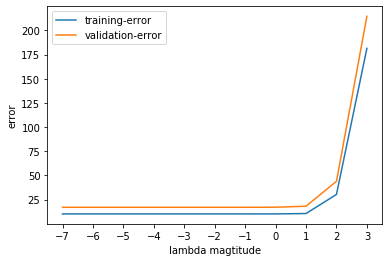

In validation set, the min error occurs when lambda is  1e-07 .


In [6]:
from tqdm import tqdm

magtitude_range = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
lambdas = [1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
training_errors = []
validation_errors = []
for l in tqdm(lambdas):
    ridge_regression = RidgeRegression(alpha=l)
    # get closed form solution
    ridge_regression.fit(X_train, y_train)
    val_y_hat = ridge_regression.predict(X_val)
    train_y_hat = ridge_regression.predict(X_train)
    training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
    val_error = square_error(y_val, val_y_hat) / y_val.shape[0]
    training_errors.append(training_error)
    validation_errors.append(val_error)

    
plt.plot(magtitude_range, np.array(training_errors), label='training-error')
plt.plot(magtitude_range, np.array(validation_errors), label='validation-error')
plt.xlabel('lambda magtitude')
plt.ylabel('error')
plt.xticks(magtitude_range)
plt.legend()
plt.show()
print("In validation set, the min error occurs when lambda is ", lambdas[np.argmin(validation_errors)], '.')

## Test best lambda's performance.
Now we test the best lambda's performance on test set. Note that all the hyper-parameter tuning must perform on validation set or training set.
And we test the final result on the test set.

In [7]:
print(10 * '*' + ' Best Ridge LinearRegression model begin ' + 10 * '*')
# the lambda is represented as alpha in the API, by default, alpha=1
ridge_regression = RidgeRegression(alpha=1e-7)
# get closed form solution
ridge_regression.fit(X_train, y_train)
test_y_hat = ridge_regression.predict(X_test)
train_y_hat = ridge_regression.predict(X_train)
training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
test_error = square_error(y_test, test_y_hat) / y_test.shape[0]
print('Training mean square error: ', training_error)
print('Test mean square error: ', test_error)
print(10 * '*' + ' Best Ridge LinearRegression model end ' + 10 * '*')
print()

********** Best Ridge LinearRegression model begin **********
Training mean square error:  10.234859706513923
Test mean square error:  10.20108157686529
********** Best Ridge LinearRegression model end **********



# Linear Regression: Optimize it using Gradient Descent

Recap: 

We have Linear model: $$ \hat{y} =  \textbf{X} \cdot \textbf{W} $$, where $$ \hat{y} \in \mathbb{R}^{m \times h}, \textbf{X} \in \mathbb{R}^{m \times (n+1)}, \mathbb{W}^{(n+1) \times h} $$

We have Loss function (Least Square Loss): 
\begin{eqnarray} J(\hat{y}, y) &=& \frac{1}{2m}(\hat{y} - y)^{T} \cdot (\hat{y} - y) \\
&=& \frac{1}{2m}(\textbf{X} \textbf{W} - y)^{T} \cdot (\textbf{X} \textbf{W} - y) \end{eqnarray} 

The Gradient w.r.t $$\textbf{W}$$ is:
 
 \begin{eqnarray} \frac{\partial J}{W} &=& \frac{1}{2m} \frac{\partial J}{\hat{y}} \frac{\partial \hat{y}}{W} \\
 &=&  \frac{1}{m} X^{T}(\textbf{X} \textbf{W} - y)   \end{eqnarray}
 
With learning rate $$\eta \in \mathbb{R} $$, which typically is a very small float number, e.g., 1e-3, 1e-4...
 
Gradient Descent Update the $$\textbf{W}$$ using the following equation.

$$ \textbf{W}_{t+1} = \textbf{W}_t - \eta \frac{\partial J}{W} $$ 

But all of the details are warp as A Layer for you to call in simple_ml.

Note that, In Gradient descent, we use all the training data to update the parameter in each run.

We can see that, using the whole data to update typically need more iterations to fully converge, comparing with Stochastic
Gradient Descent(SGD) or Mini Batch Gradient Descent(MBGD).
But GD fully use the vectorization computation, which make it super fast, you can see that, the whole process uses less 
than 1 seconds.

********** GD Linear model **********

epoch   100/  500, train-[loss: 151.0251 | metric: 16.7722]; valid-[loss: 169.0063 | metric: 17.4362]; 

epoch   200/  500, train-[loss: 79.6740 | metric: 11.8090]; valid-[loss: 94.3253 | metric: 12.4362]; 

epoch   300/  500, train-[loss: 33.3229 | metric: 6.9051]; valid-[loss: 44.6442 | metric: 7.4435]; 

epoch   400/  500, train-[loss: 13.8171 | metric: 3.6714]; valid-[loss: 22.4478 | metric: 4.1860]; 

epoch   500/  500, train-[loss: 10.8621 | metric: 3.1692]; valid-[loss: 18.3777 | metric: 3.7613]; 
Training error:  10.878732872751796
Test error:  11.263108760235651
Cost:  0:00:00.170543  seconds
********** GD Linear model end **********



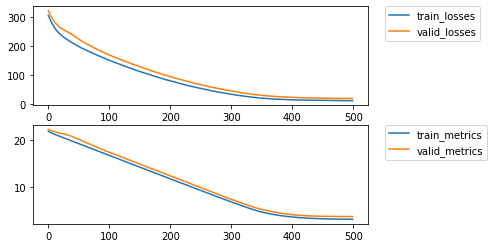

In [8]:
from datetime import datetime
print(10 * '*' + ' GD Linear model ' + 10 * '*')

# build the linear model with gradient descent
# define layer
Inputs = Input(input_shape=X_train.shape[1])
linear_out = Linear(output_dim=1, activation=None, initializer=ones)(Inputs)
model = Model(Inputs, linear_out)
model.compile('MSE', optimizer=SGD(lr=0.01))
begin = datetime.now()
model.fit(X_train, y_train,
          verbose=100, epochs=500,
          validation_data=(X_val, y_val),
          batch_size=X_train.shape[0], # here we set batch_size 
                                       # equal to number of training examples 
                                       # to implement Gradient Descent.
                                
          metric='MAE',
          shuffle=False,
          # peek_type='single-reg'
          )
end = datetime.now()
plt.subplot(211)
plt.plot(model.train_losses, label='train_losses')
plt.plot(model.validation_losses, label='valid_losses')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(model.train_metrics, label='train_metrics')
plt.plot(model.validation_metrics, label='valid_metrics')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

train_y_hat = model.forward(X_train)
test_y_hat = model.forward(X_test)
training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
test_error = square_error(y_test, test_y_hat) / y_test.shape[0]

print('Training error: ', training_error)
print('Test error: ', test_error)
print('Cost: ',  (end - begin), ' seconds')
print(10 * '*' + ' GD Linear model end ' + 10 * '*')
print()

# Linear Regression: Optimize it using Stochastic Gradient Descent(SGD)

Note that, In Stochastic Gradient descent, we use one training example to update the parameter in each run.

We can see that, SGD brings fast convergence compared with GD.
But SGD hasn't use the vectorization computation at all, which make it super slow, you can see that, the whole process uses 25x 
times more than GD.

********** SGD Linear model **********

epoch   100/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   200/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   300/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   400/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   500/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 
Training error:  11.729031443180421
Test error:  11.494790524328314
Cost:  0:00:24.447696  seconds
********** SGD Linear model end **********



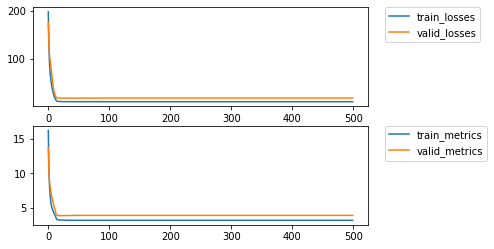

In [9]:
print(10 * '*' + ' SGD Linear model ' + 10 * '*')

# build the linear model with gradient descent
# define layer
Inputs = Input(input_shape=X_train.shape[1])
linear_out = Linear(output_dim=1, activation=None, initializer=ones)(Inputs)
model = Model(Inputs, linear_out)
model.compile('MSE', optimizer=SGD(lr=0.01))
begin = datetime.now()
model.fit(X_train, y_train,
          verbose=100, epochs=500,
          validation_data=(X_val, y_val),
          batch_size=1, # here we set batch_size = 1 
                        # to implement Stochastic Gradient Descent.
                                
          metric='MAE',
          shuffle=False,
          # peek_type='single-reg'
          )
end = datetime.now()
plt.subplot(211)
plt.plot(model.train_losses, label='train_losses')
plt.plot(model.validation_losses, label='valid_losses')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
plt.plot(model.train_metrics, label='train_metrics')
plt.plot(model.validation_metrics, label='valid_metrics')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

train_y_hat = model.forward(X_train)
test_y_hat = model.forward(X_test)
training_error = square_error(y_train, train_y_hat) / y_train.shape[0]
test_error = square_error(y_test, test_y_hat) / y_test.shape[0]

print('Training error: ', training_error)
print('Test error: ', test_error)
print('Cost: ',  (end - begin), ' seconds')
print(10 * '*' + ' SGD Linear model end ' + 10 * '*')
print()

# Linear Regression: Optimize it using Mini Batch Gradient Descent(MBGD)

In the above comparision between GD and SGD, we can clearly see that:

|      Metric     |       GD      |      SGD      |
| --------------- | ------------- | ------------- |
| Time-Efficiency |       Yse     |       No      |
| Convergence     |      Slow     |      Fast     |

Clearly there is a trade off to be made. But how can we balance the trade off ?

The key is to control the batch_size.
- GD: batch_size: all examples
- SGD: batch_size: 1
- MBGD: batch_size: between 1 and all examples, typically 16, 32, 64...

Now we compare the influence w.r.t time efficiency and convergence.

As stated before, GD and MBGD both have its metric and drawback, what we can do is making trade off.
As illustrated by the following three graphs, the smaller the batch_size, the faster for convergence,
but cost more time. So in practice, we set batch_size bigger than one, but smaller than the number of 
examples, typically 32, 64, 128...

Starting with batch_size = 1

epoch   100/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   200/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   300/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   400/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 

epoch   500/  500, train-[loss: 11.3766 | metric: 3.2200]; valid-[loss: 18.9352 | metric: 3.9294]; 
End with batch_size = 1

Starting with batch_size = 8

epoch   100/  500, train-[loss: 10.9384 | metric: 3.3299]; valid-[loss: 17.6296 | metric: 3.9544]; 

epoch   200/  500, train-[loss: 10.9387 | metric: 3.3300]; valid-[loss: 17.6288 | metric: 3.9541]; 

epoch   300/  500, train-[loss: 10.9387 | metric: 3.3300]; valid-[loss: 17.6288 | metric: 3.9541]; 

epoch   400/  500, train-[loss: 10.9387 | metric: 3.3300]; valid-[loss: 17.6288 | metric: 3.9541]; 

epoch  

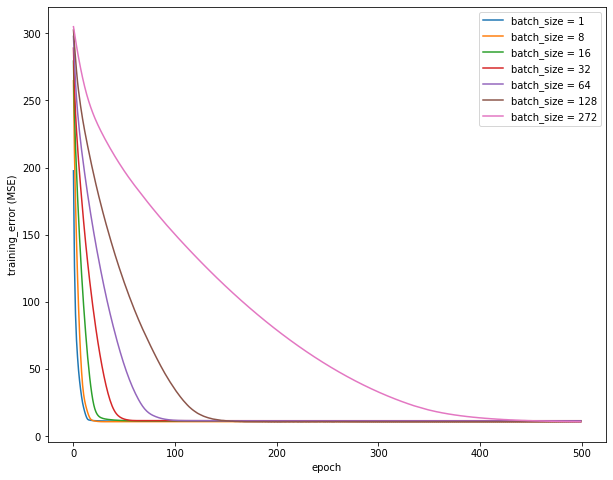

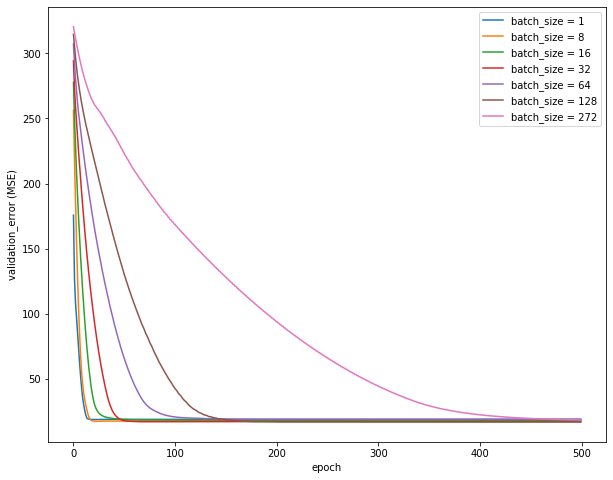

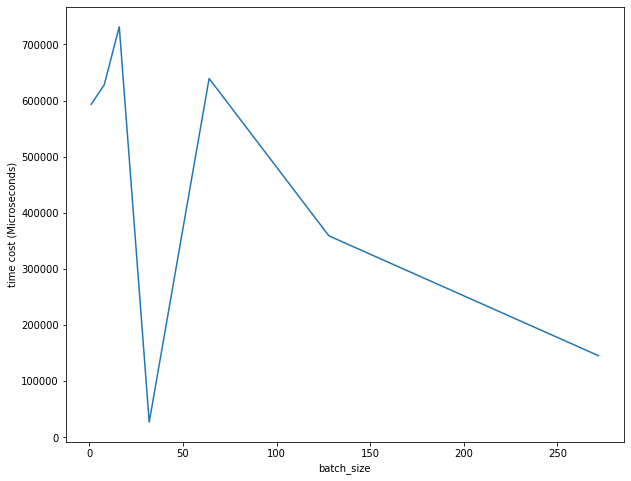

In [12]:
batch_sizes = [1, 8, 16, 32, 64, 128, X_train.shape[0]]
batch_size2training_losses = {b: None for b in batch_sizes}
batch_size2validation_losses = {b: None for b in batch_sizes}
batch_size2timecost = []

for b in batch_sizes:
    print('Starting with batch_size = %d' % b)
    Inputs = Input(input_shape=X_train.shape[1])
    linear_out = Linear(output_dim=1, activation=None, initializer=ones)(Inputs)
    model = Model(Inputs, linear_out)
    model.compile('MSE', optimizer=SGD(lr=0.01))
    begin = datetime.now()
    model.fit(X_train, y_train,
              verbose=100, epochs=500,
              validation_data=(X_val, y_val),
              batch_size=b, # here we set batch_size with a bunch of sizes 
                            # to implement both SGD, MBGD and GD               
              metric='MAE',
              shuffle=False,
              # peek_type='single-reg'
              )
    end = datetime.now()
    cost = (end - begin).microseconds
    batch_size2training_losses[b] = model.train_losses
    batch_size2validation_losses[b] = model.valid_losses
    batch_size2timecost.append(cost)
    print('End with batch_size = %d\n' % b)

for b in batch_sizes:
    plt.plot(batch_size2training_losses[b], label='batch_size = %d' % b)
plt.xlabel('epoch')
plt.ylabel('training_error (MSE)')
plt.legend()
plt.show()

for b in batch_sizes:
    plt.plot(batch_size2validation_losses[b], label='batch_size = %d' % b)
plt.xlabel('epoch')
plt.ylabel('validation_error (MSE)')
plt.legend()
plt.show()

plt.plot(batch_sizes, batch_size2timecost)
plt.xlabel('batch_size')
plt.ylabel('time cost (Microseconds)')
plt.show()

# Tuning Hyper-Parameter
Now it's time to tuning the hyper-parameter of Gradient Descent Algorithm.
In the simple GD, the only hyper-parameter is learning rate $$\eta$$.

Now we validate the best $$ \eta $$ in validation set and test our final model.
We first search it in log space, e.g., 1e-4, 1e-3, 1e-2, 1e-1, 1.
As Bigger learning rate will lead to very big loss, we do not try it here.
As seen below, the best learning rate is 1e-2.

The bigger the learning rate, the faster the loss decreases, but it may not converge to a very low loss.

The smaller the learning rate, it may converge to a very low loss, but the loss decrease very slowly. 

Starting with learning_rate = 0.0001

epoch   200/  500, train-[loss: 267.9317 | metric: 21.2219]; valid-[loss: 292.2468 | metric: 21.8820]; 

epoch   400/  500, train-[loss: 244.6259 | metric: 20.7219]; valid-[loss: 270.6755 | metric: 21.5300]; 
End with learning_rate = 0.0001

Starting with learning_rate = 0.0010

epoch   200/  500, train-[loss: 153.0007 | metric: 16.7388]; valid-[loss: 174.7114 | metric: 17.5800]; 

epoch   400/  500, train-[loss: 79.8716 | metric: 11.7727]; valid-[loss: 96.8457 | metric: 12.5514]; 
End with learning_rate = 0.0010

Starting with learning_rate = 0.0100

epoch   200/  500, train-[loss: 11.4910 | metric: 3.5127]; valid-[loss: 19.0369 | metric: 4.2848]; 

epoch   400/  500, train-[loss: 11.4918 | metric: 3.5136]; valid-[loss: 19.0333 | metric: 4.2856]; 
End with learning_rate = 0.0100

Starting with learning_rate = 0.1000

epoch   200/  500, train-[loss: 14.3629 | metric: 3.7636]; valid-[loss: 36.7210 | metric: 7.0146]; 

epoch   400/  500, train-[loss:

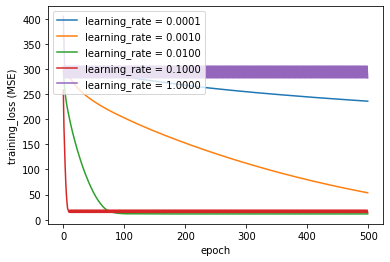

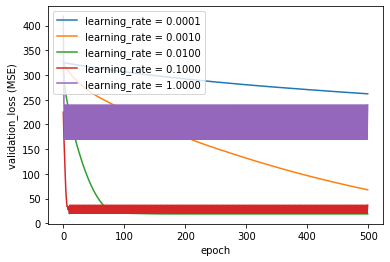

In [11]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1]
training_losses = []
validation_losses = []

for lr in learning_rates:
    print('Starting with learning_rate = %.4f' % lr)
    Inputs = Input(input_shape=X_train.shape[1])
    linear_out = Linear(output_dim=1, activation=None, initializer=ones)(Inputs)
    model = Model(Inputs, linear_out)
    model.compile('MSE', optimizer=SGD(lr=lr))
    model.fit(X_train, y_train,
              verbose=200, epochs=500, # we set epochs to 1000 for fully convergence
              validation_data=(X_val, y_val),
              batch_size=64, # here we set batch_size to 64 considering the trade off            
              metric='MAE',
              shuffle=False,
              # peek_type='single-reg'
              )
    training_losses.append(model.training_losses)
    validation_losses.append(model.valid_losses)
    print('End with learning_rate = %.4f\n' % lr)

for lr, train_loss in zip(learning_rates, training_losses):
    plt.plot(train_loss, label='learning_rate = %.4f' % lr)
plt.xlabel('epoch')
plt.ylabel('training_loss (MSE)')
plt.legend( loc='upper left')
plt.show()

for lr, val_loss in zip(learning_rates, validation_losses):
    plt.plot(val_loss, label='learning_rate = %.4f' % lr)
plt.xlabel('epoch')
plt.ylabel('validation_loss (MSE)')
plt.legend( loc='upper left')
plt.show()

## The Difference of $$\textbf{W}$$
Now we explore the differences of $$\textbf{W}$$ in Closed Form Solution, Ridge Regression and MBGD.

More specifically, we will evaluate the $$l_2norm$$ of $$\textbf{W}$$ under different setting.

Given $$ \textbf{x} \in \mathbb{R}^{n} $$, $$ l_2norm(\textbf{x}) = \sqrt{\Sigma_{i=1}^{n}\textbf{x}_{i}^{2}}$$

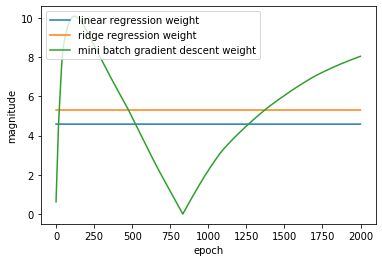

In [14]:
linear_regression = LinearRegression()
ridge_regression = RidgeRegression(alpha=1) 
 # use the best learning rate here.

linear_regression.fit(X_train, y_train)
ridge_regression.fit(X_train, y_train)
NUM_EPOCH = 2000

linear_Ws = NUM_EPOCH * [np.linalg.norm(linear_regression.beta[1:], ord=2, axis=1)[0]]
ridge_Ws = NUM_EPOCH * [np.linalg.norm(ridge_regression.beta[1:], ord=2, axis=1)[0]]

MBGD_Ws = []
linear_out = Linear(output_dim=1, activation=None)(Inputs)
MBGD_linear_regression = Model(Inputs, linear_out)

for epoch in range(NUM_EPOCH):
    Inputs = Input(input_shape=X_train.shape[1])
    MBGD_linear_regression.compile('MSE', optimizer=SGD(lr=0.01)) # use the best lambda here.
    MBGD_linear_regression.fit(X_train, y_train,
              verbose=-1, epochs=1, # we set epochs to 1000 for fully convergence
              validation_data=(X_val, y_val),
              batch_size=64, # here we set batch_size to 64 considering the trade off            
              metric='MAE',
              shuffle=False)
    MBGD_Ws.append(np.linalg.norm(linear_out.weight.T, ord=2, axis=1)[0])
    
plt.plot(linear_Ws, label='linear regression weight')
plt.plot(ridge_Ws, label='ridge regression weight')
plt.plot(MBGD_Ws, label='mini batch gradient descent weight')
plt.xlabel('epoch')
plt.ylabel('magnitude')
plt.legend( loc='upper left')
plt.show()